# Collect and filter AlphaFold output

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob, iglob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


#### First look at predictions of MSD designs starting from af2 models ####

In [2]:
scores_df = pd.read_csv(
    '06_alphafold_two_state/05_run_2_af2/af2_complex_prediction_runs_combined.sc',
    sep=' ',
    index_col='description',
    usecols=list(range(1,12)))
scores_df

,pae_binder,pae_interaction,pae_interaction1,pae_interaction2,pae_target,plddt_binder,plddt_target,plddt_total,rmsd,time
description,,,,,,,,,,
c6ad08a2342d7f1b21ada75c86ac3b1bcd6d9d943920d0f6_af2pred,3.447,27.637,27.840,27.434,3.094,94.055,95.116,94.586,11.045,247.523
c6b48ec70656d6ca3eae804857144d1c53148b08589d04e3_af2pred,3.850,27.492,27.364,27.621,7.633,92.640,88.859,90.749,20.561,39.466
c6cfe1d0e7b9bd902bb54e8cc4f41a61d58538eca47b9f46_af2pred,2.974,26.732,26.980,26.484,3.196,95.450,94.677,95.064,20.274,40.205
c6eaaeb68fc1d32661cbe028eedbd7e05f1b4e6e84df6724_af2pred,4.174,26.464,26.759,26.169,3.851,91.886,93.120,92.503,19.335,40.049
c82b15bbfa4766a335cf3b840f51590b15750223efde4b4d_af2pred,6.691,27.082,27.248,26.916,5.434,88.240,90.934,89.587,21.178,40.210
...,...,...,...,...,...,...,...,...,...,...
eca8e2ceab1d707212da33fb3dd9928810806a28d5ec12a9_af2pred,10.217,27.972,28.079,27.866,11.236,83.118,83.215,83.167,23.727,38.928
f2070246df0972a266687ebeccf2a6cd8dee06bbf3499089_af2pred,4.100,27.272,26.528,28.017,12.444,92.971,75.782,84.376,19.678,38.915
f39290cb635e862e27d201511b6442f12d2f9f20af1b034e_af2pred,5.795,27.222,27.137,27.308,7.542,88.704,84.307,86.505,22.089,38.886


5it [00:00, 12.78it/s]


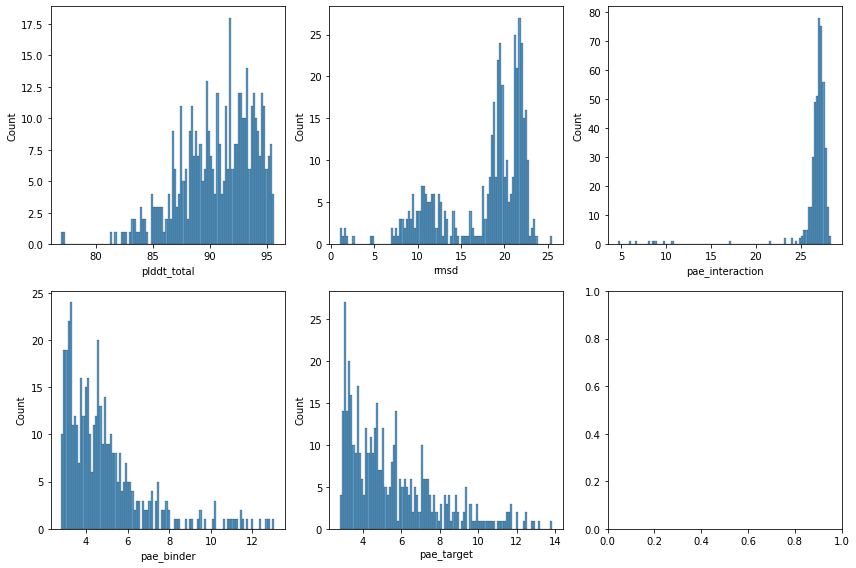

In [3]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "plddt_total",
        "rmsd",
        "pae_interaction",
        "pae_binder",
        "pae_target",
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

# pairplot these as well

In [4]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

In [5]:
# Filter designs

cutoffs = [
    ('plddt_total', 85, 1),
    ('rmsd', 3, 0)
]

filtered_df = filter_df(scores_df, cutoffs)
filtered_df

7


,pae_binder,pae_interaction,pae_interaction1,pae_interaction2,pae_target,plddt_binder,plddt_target,plddt_total,rmsd,time
description,,,,,,,,,,
e1ec046f2dd7f6bf64d77b6370e71d294dbcccf1832d92a8_af2pred,4.746,10.772,10.644,10.900,8.861,87.937,85.993,86.965,2.666,78.652
fac96a7e2e6d4e922af4bbfc4d6171c97dbc3bbfc1922a85_af2pred,5.041,8.842,9.030,8.654,7.100,87.787,88.559,88.173,1.567,78.823
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_af2pred,5.916,8.501,8.432,8.570,4.791,88.775,89.644,89.210,1.340,41.499
bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_af2pred,4.561,6.060,6.200,5.919,3.502,91.325,93.560,92.443,1.027,41.575
57eb528a8d006f24a64426f6303405ee22ed8d5be5a5b8c5_af2pred,5.232,6.575,6.926,6.224,4.764,87.418,89.888,88.653,1.723,78.348
bb3ef9dff37ccf386311cad785ff807cb570b0d3a30a5a24_af2pred,5.946,9.788,9.876,9.699,7.412,84.949,86.463,85.706,1.926,79.944
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_af2pred,3.418,4.670,4.718,4.621,3.148,93.860,95.000,94.430,1.153,41.848


In [15]:
print(f"echo \"{' '.join(filtered_df.index)}\" | silentextractspecific ../af2_predictions.silent")


echo "e1ec046f2dd7f6bf64d77b6370e71d294dbcccf1832d92a8_af2pred fac96a7e2e6d4e922af4bbfc4d6171c97dbc3bbfc1922a85_af2pred 95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_af2pred bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_af2pred 57eb528a8d006f24a64426f6303405ee22ed8d5be5a5b8c5_af2pred bb3ef9dff37ccf386311cad785ff807cb570b0d3a30a5a24_af2pred 2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_af2pred" | silentextractspecific ../af2_predictions.silent


In [6]:
with open('06_alphafold_two_state/05_run_2_af2/predicted_dimers.list', 'w') as f:
    for file in sorted(filtered_df.index):
        f.write('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/af2_decoys/' + file[:-8] + '.pdb\n')

#### Now look at predictions of MSD designs starting from design models ####

In [7]:
scores_df = pd.read_csv(
    '06_alphafold_two_state/05_run_2_des/af2_complex_prediction_runs_combined.sc',
    sep=' ',
    index_col='description',
    usecols=list(range(1,12)))
scores_df

,pae_binder,pae_interaction,pae_interaction1,pae_interaction2,pae_target,plddt_binder,plddt_target,plddt_total,rmsd,time
description,,,,,,,,,,
c9c424337a415d1aad69421122bd0736fbcf73987f9370ed_af2pred,5.634,27.003,27.327,26.678,3.453,88.852,93.904,91.378,20.954,235.460
cc667bb725e3602915fedea4c65ead239136e5da3f3742e7_af2pred,3.119,26.709,26.449,26.969,4.259,95.194,92.183,93.688,21.809,40.101
ccf498f69226b1cd8d66a7bd43ab7ec6004d546c004aae46_af2pred,3.060,26.876,26.974,26.778,2.981,95.192,95.382,95.287,21.670,40.170
ce4f5ec915372ec906042b72da9f4a385bd949db0a05b1ff_af2pred,4.871,26.589,26.952,26.226,3.083,89.663,94.745,92.204,21.648,40.069
ce96bbca383158252475334cfd3db6ce04b46079d3ee4a80_af2pred,4.621,27.122,27.376,26.869,3.331,90.384,94.106,92.245,21.582,40.182
...,...,...,...,...,...,...,...,...,...,...
c56b69ba5963401fb54f6f75ac57291bf19e2eb26a706261_af2pred,3.658,26.590,26.687,26.494,2.963,93.273,95.701,94.487,21.135,40.080
c634a779921d9c1aaaca93bb8e9118d8846f6f08da3a2e41_af2pred,3.582,26.887,26.703,27.070,4.668,93.539,91.003,92.271,21.535,40.178
c751c5c9aece52af570c5a2b024ecb22684b2e2620ed0942_af2pred,3.490,27.105,26.865,27.345,4.213,93.832,91.820,92.826,11.728,40.239


5it [00:00, 10.52it/s]


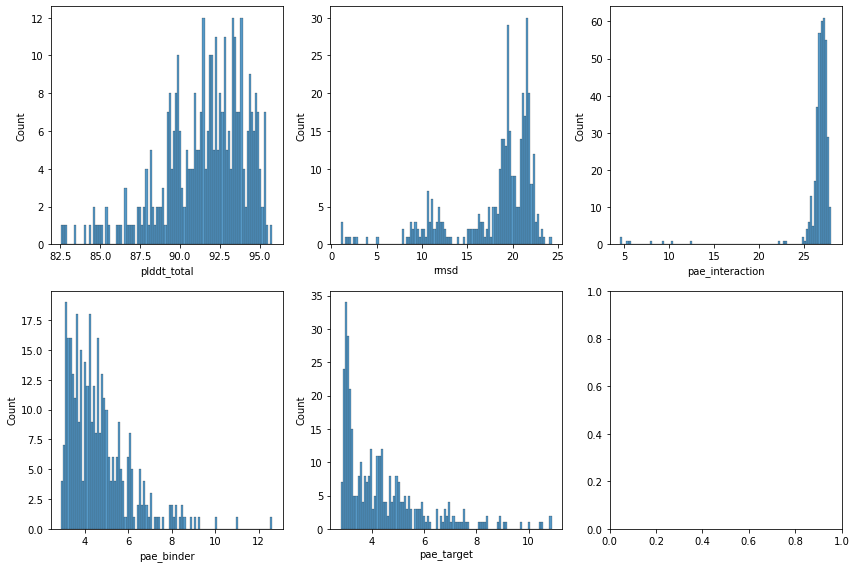

In [8]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "plddt_total",
        "rmsd",
        "pae_interaction",
        "pae_binder",
        "pae_target",
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

# pairplot these as well

In [9]:
# Filter designs

cutoffs = [
    ('plddt_total', 85, 1),
    ('rmsd', 3, 0)
]

filtered_df = filter_df(scores_df, cutoffs)
filtered_df

8


,pae_binder,pae_interaction,pae_interaction1,pae_interaction2,pae_target,plddt_binder,plddt_target,plddt_total,rmsd,time
description,,,,,,,,,,
f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f_af2pred,6.567,9.396,9.958,8.833,3.679,84.033,90.624,87.328,1.948,40.106
fd33f41915ceee09df616b7d6eae037a8397b6ccbe052285_af2pred,3.394,4.789,4.792,4.786,3.379,93.737,94.205,93.971,1.030,40.255
03d724605623c4d0d5047b13eda8677ec5d84c7a542f7c21_af2pred,4.113,5.647,5.705,5.590,3.924,91.263,92.897,92.080,1.199,41.020
612e355023747c73c83c270643ae624baaee4a4d5ab2b5b5_af2pred,3.826,10.266,9.909,10.623,8.400,90.722,88.603,89.663,2.656,40.521
e1dc56163dfeea4a0e309c3a8c1d188a0fea675943e36949_af2pred,5.799,12.540,12.521,12.559,10.532,85.062,84.960,85.011,2.879,80.628
7c4719e839ddece8c50e157c72e750b2378c5ce59839051f_af2pred,3.114,4.572,4.581,4.563,3.500,94.512,94.436,94.474,1.547,40.174
88b3ee4df312f18141e3e0acdd6bfee746919bb0a2e49e4c_af2pred,3.348,5.405,5.279,5.532,4.195,93.440,92.678,93.059,1.098,40.162
a06f5b66c3d59cb31905dd9025e38d5f76037dd95202cfd6_af2pred,4.029,8.012,7.823,8.201,6.800,91.611,90.745,91.178,1.964,40.097


In [22]:
print(f"echo \"{' '.join(filtered_df.index)}\" | silentextractspecific ../af2_predictions.silent")

echo "f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f_af2pred fd33f41915ceee09df616b7d6eae037a8397b6ccbe052285_af2pred 03d724605623c4d0d5047b13eda8677ec5d84c7a542f7c21_af2pred 612e355023747c73c83c270643ae624baaee4a4d5ab2b5b5_af2pred e1dc56163dfeea4a0e309c3a8c1d188a0fea675943e36949_af2pred 7c4719e839ddece8c50e157c72e750b2378c5ce59839051f_af2pred 88b3ee4df312f18141e3e0acdd6bfee746919bb0a2e49e4c_af2pred a06f5b66c3d59cb31905dd9025e38d5f76037dd95202cfd6_af2pred" | silentextractspecific ../af2_predictions.silent


In [ ]:
with open('06_alphafold_two_state/05_run_2_des/predicted_dimers.list', 'w') as f:
    for file in sorted(filtered_df.index):
        f.write('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/design_decoys/' + file[:-8] + '.pdb\n')

In [ ]:
# TODO add scores back in and plot Rosetta metrics